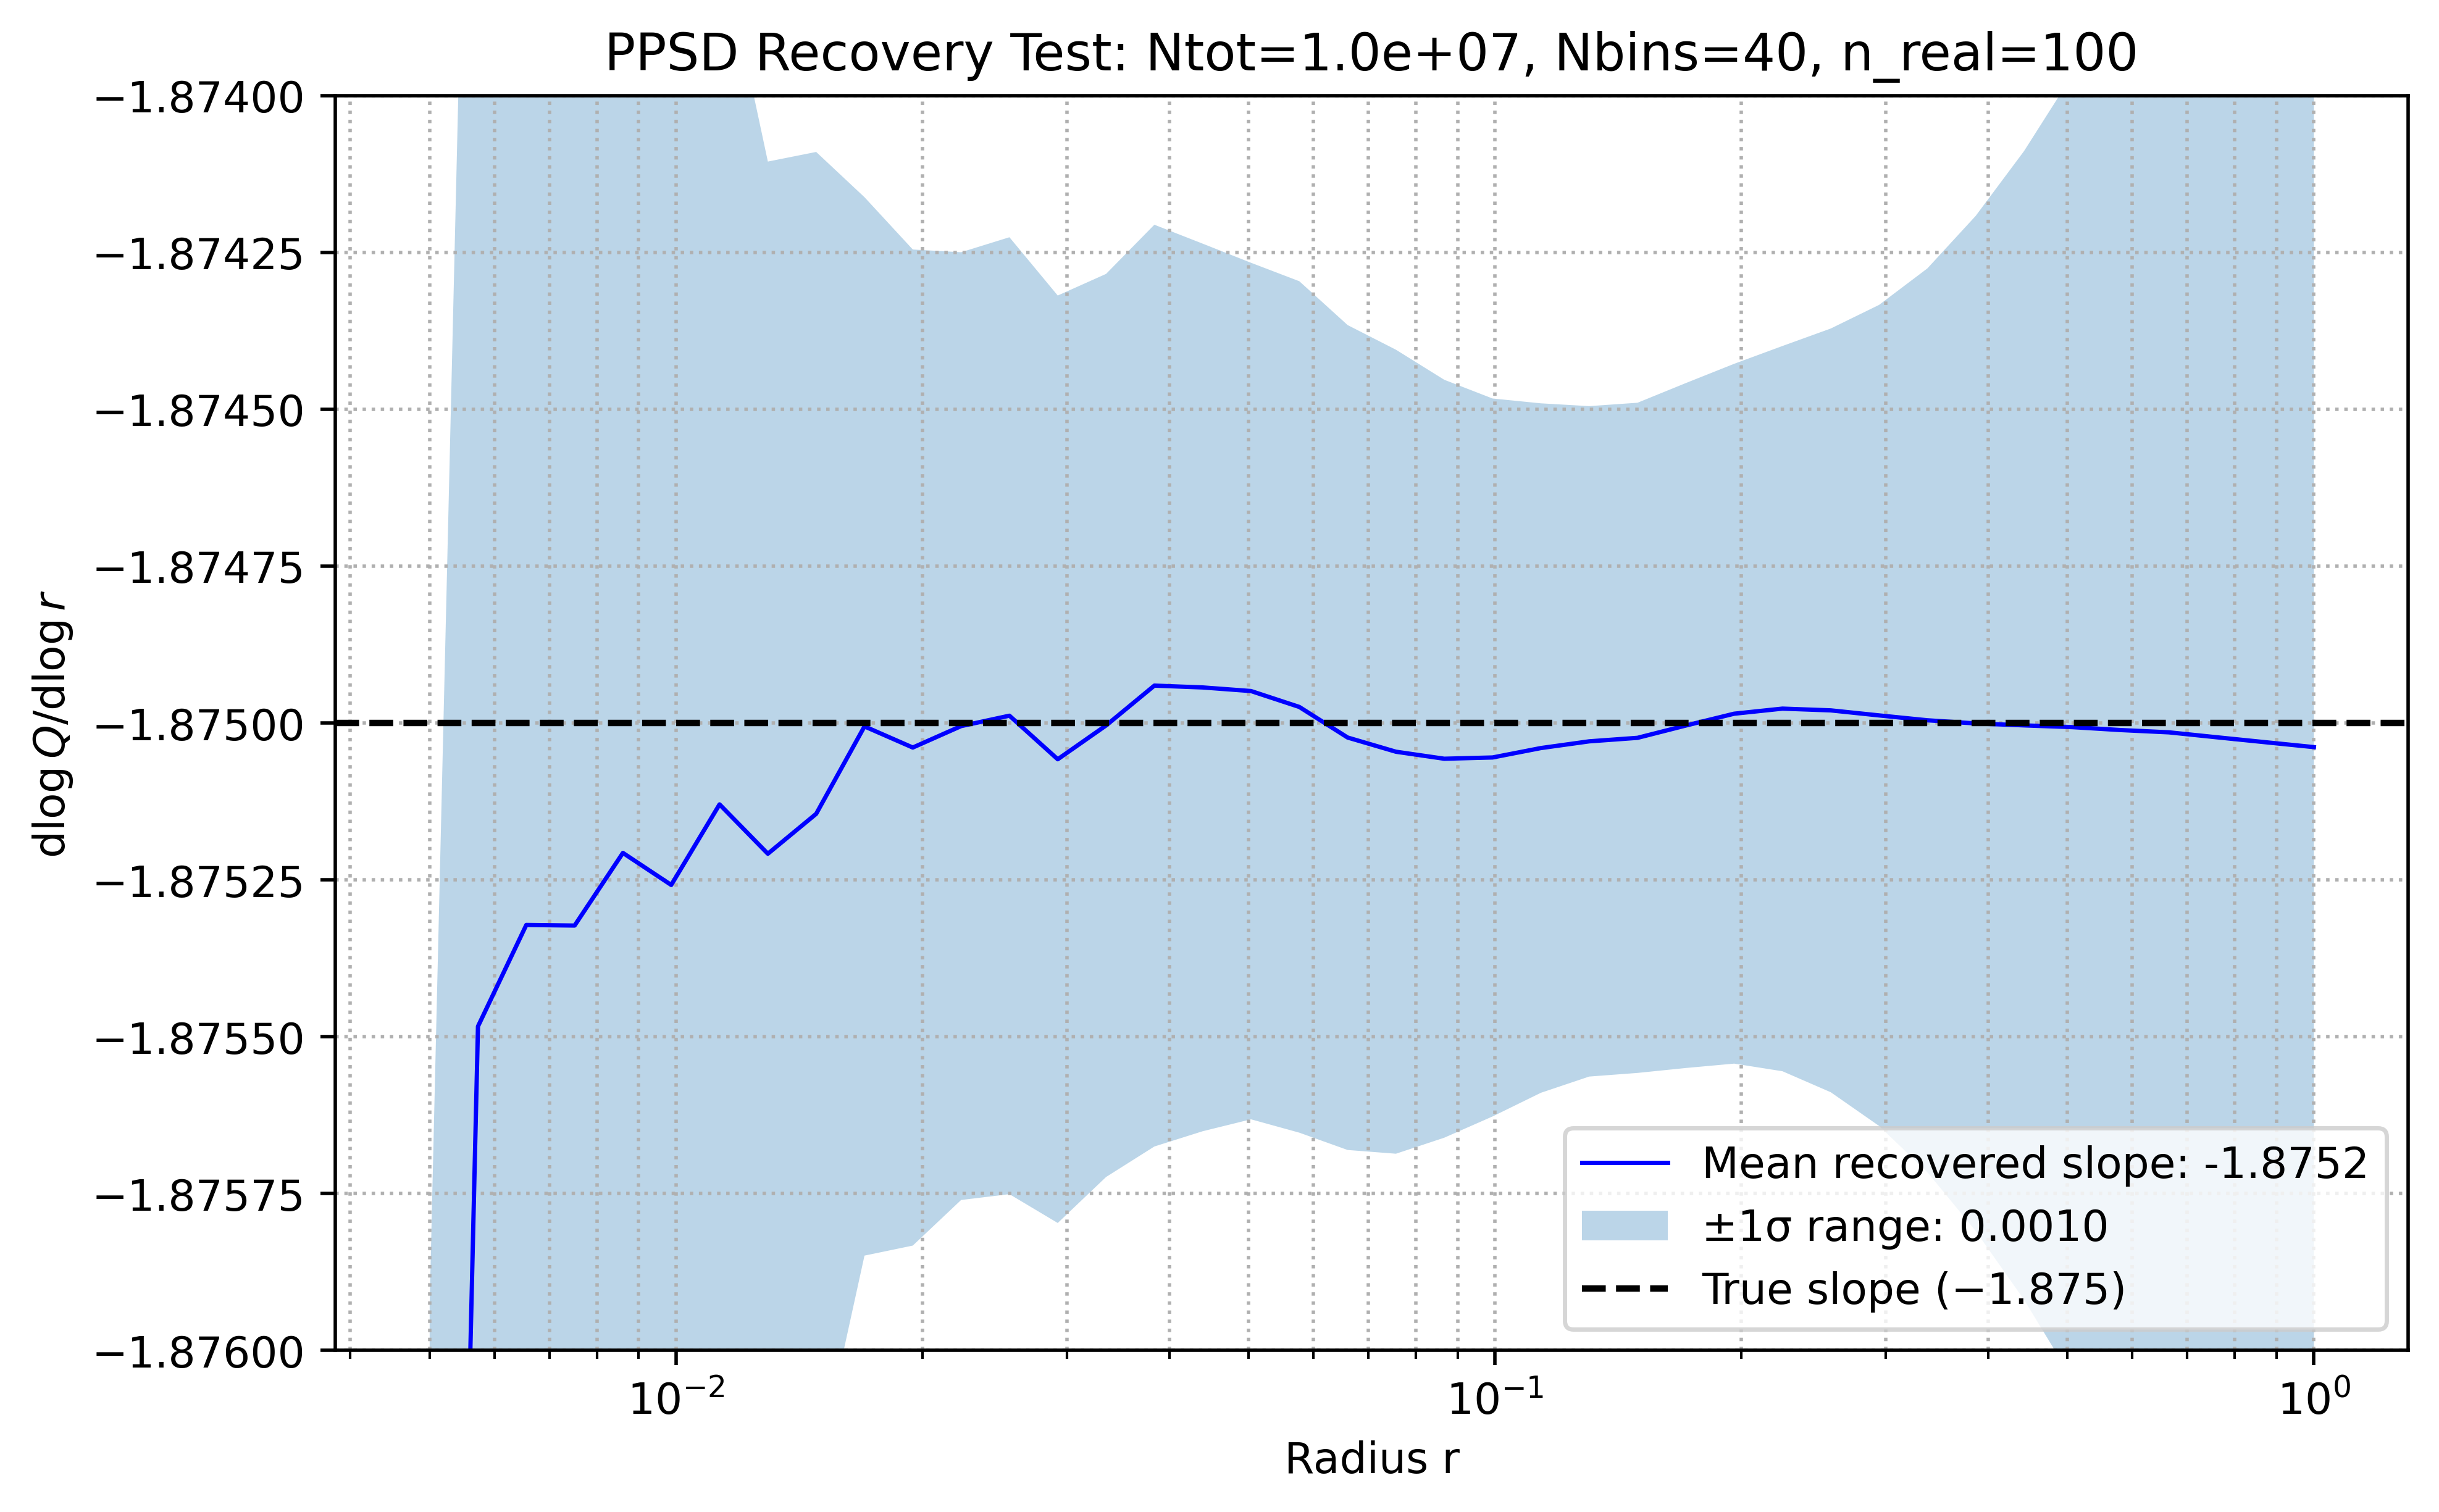

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks

def recovery_test_multiple(Ntot, Nbins, chi, rmin, rmax, n_real=100):
    """
    Perform PPSD recovery test with multiple noisy realizations.
    
    Parameters:
    - Ntot: int
        Total number of particles in the mock halo.
    - Nbins: int
        Number of logarithmic radial bins.
    - chi: float
        True PPSD exponent (e.g. 1.875).
    - rmin, rmax: floats
        Minimum and maximum radius for the profile (e.g. [0.01, 1.0]).
    - n_real: int, optional
        Number of noisy realizations to average over.
        
    Returns:
    - mean_slope: ndarray
        Mean of recovered slopes across all realizations.
    - rms_slope: ndarray
        RMS of recovered slopes across all realizations.
    """
    r = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r = np.log10(r)
    
    # Collect slopes for all realizations
    all_slopes = []
    for _ in range(n_real):
        Q_true = r**(-chi)
        Ni = Ntot / Nbins
        sigma_poisson = 1.0 / np.sqrt(Ni)
        noise = np.random.normal(0, sigma_poisson, size=Nbins)
        Q_noisy = Q_true * (1 + noise)
        log_Q_noisy = np.log10(Q_noisy)

        # Recover slope via kalman_smooth.constant_jerk
        dt = np.mean(np.diff(log_r))
        params, _ = ks_opt.constant_jerk(log_Q_noisy, dt)
        _, slope = ks.constant_jerk(log_Q_noisy, dt, params)
        all_slopes.append(slope)

    # Convert to arrays for easy calculation
    all_slopes = np.array(all_slopes)

    # Calculate mean and RMS of the recovered slopes
    mean_slope = np.mean(all_slopes, axis=0)
    rms_slope = np.std(all_slopes, axis=0)

    # Calculate bias
    bias = np.mean(mean_slope) - (-chi)

    mean_slope_value = np.mean(mean_slope)
    rms_slope_value = np.mean(rms_slope)
    plt.figure(figsize=(8, 5), dpi=500)
    plt.plot(r, mean_slope, label=f'Mean recovered slope: {mean_slope_value:.4f}', color='blue', lw=1)
    plt.ylim(-1.876, -1.874)
    plt.fill_between(r, mean_slope - rms_slope, mean_slope + rms_slope, alpha=0.3, label=f'±1σ range: {rms_slope_value:.4f}')
    plt.axhline(-chi, ls='--', color='k', label=f'True slope (−{chi})')
    plt.xscale('log')
    plt.xlabel('Radius r')
    plt.ylabel(r'$\mathrm{d}\log Q / \mathrm{d}\log r$')
    plt.title(f'PPSD Recovery Test: Ntot={Ntot:.1e}, Nbins={Nbins}, n_real={n_real}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()

recovery_test_multiple(Ntot=1e7, Nbins=40, chi=1.875, rmin=5e-3, rmax=1, n_real=100)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks

def noisy_Q_profile(chi, r, Ntot):
    """
    Return (Q_true, Q_noisy) for a power-law PPSD Q=r^{-chi} with Poisson noise.

    Parameters
    ----------
    chi   : float   underlying slope (e.g. 1.875)
    r     : ndarray radial grid
    Ntot  : int     total particle count in the mock halo
    """
    Q_true = r**(-chi)

    # Poisson counts → fractional fluctuation
    Ni      = Ntot / len(r)
    sigma_poisson = 1.0 / np.sqrt(Ni)                       # expected per bin
    noise  = np.random.normal(0, sigma_poisson, size=len(r)) 
    Q_noisy = Q_true * (1 + noise)
    return Q_true, Q_noisy

# ================================================================
# A) Slope vs radius for many noise realizations using constant jerk
# ================================================================
def plot_slope_vs_radius(chi=1.875, Ntot=int(1e7), Nbins=40,
                         n_real=50, rmin=5e-3, rmax=1.0):
    """
    Multiple noisy realizations; recovered slope dlogQ/dlogr vs r using constant jerk.
    """
    r      = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r  = np.log10(r)

    plt.figure(figsize=(8, 5), dpi=500)
    for _ in range(n_real):
        _, Qn = noisy_Q_profile(chi, r, Ntot)  # Poisson noise
        dt = np.mean(np.diff(log_r))  # Calculate the log spacing
        params, _ = ks_opt.constant_jerk(np.log10(Qn), dt)  # Kalman smoothing (constant jerk)
        _, slope = ks.constant_jerk(np.log10(Qn), dt, params)  # Get the smoothed slope
        plt.plot(r, slope, color='steelblue', alpha=0.3)

    plt.axhline(-chi, ls='--', color='k', label=f'True slope −{chi}')
    plt.xscale('log')
    plt.xlabel('Radius $r$')
    plt.ylabel(r'$\mathrm{d}\log Q/\mathrm{d}\log r$')
    plt.title('Slope recovery across radius using constant jerk')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================================================
# B) Bias of mean recovered slope vs total particle count using constant jerk
# ================================================================
def plot_bias_vs_particle_count(chi=1.875, Nbins=40,
                                 Ntot_list=(1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8),
                                 n_real=50, rmin=5e-3, rmax=1.0):
    """
    Mean recovered slope ⟨χ̂⟩ (with 1σ error) vs Ntot using constant jerk.
    """
    means, errs = [], []
    r     = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r = np.log10(r)

    for Ntot in Ntot_list:
        slopes = []
        for _ in range(n_real):
            _, Qn = noisy_Q_profile(chi, r, Ntot)
            dt = np.mean(np.diff(log_r))  # Calculate the log spacing
            params, _ = ks_opt.constant_jerk(np.log10(Qn), dt)  # Kalman smoothing (constant jerk)
            _, slope = ks.constant_jerk(np.log10(Qn), dt, params)  # Get the smoothed slope
            slopes.append(np.mean(slope))
        means.append(np.mean(slopes))
        errs.append(np.std(slopes))

    plt.figure(figsize=(7, 5), dpi=500)
    plt.errorbar(Ntot_list, means, yerr=errs, fmt='o', capsize=3,
                 label='Recovered mean')
    plt.axhline(-chi, color='k', ls='--', label='True slope')
    plt.xscale('log')
    plt.xlabel('Total particles $N_{\\rm tot}$')
    plt.ylabel(r'$\langle\hat\chi\rangle$')
    plt.title('Bias vs particle count using constant jerk')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================================================
# C) Scatter vs Poisson 1/√N expectation using constant jerk
# ================================================================
def plot_scatter_vs_noise_expectation(chi=1.875, Nbins=80,
                                      Ntot_list=(1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8),
                                      n_real=50, rmin=5e-3, rmax=1.0):
    """
    RMS scatter of recovered slopes vs theoretical 1/sqrt(N) expectation using constant jerk.
    """
    scat_meas, scat_exp = [], []
    r     = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r = np.log10(r)

    for Ntot in Ntot_list:
        rms_theory = 1 / np.sqrt(Ntot / Nbins)
        scat_exp.append(rms_theory)

        per_real = []
        for _ in range(n_real):
            _, Qn = noisy_Q_profile(chi, r, Ntot)
            dt = np.mean(np.diff(log_r))  # Calculate the log spacing
            params, _ = ks_opt.constant_jerk(np.log10(Qn), dt)  # Kalman smoothing (constant jerk)
            _, slope = ks.constant_jerk(np.log10(Qn), dt, params)  # Get the smoothed slope
            per_real.append(np.std(slope))
        scat_meas.append(np.mean(per_real))

    plt.figure(figsize=(7, 5), dpi=500)
    plt.plot(Ntot_list, scat_meas, 'o-', label='Measured RMS')
    plt.plot(Ntot_list, scat_exp,  'k--', label=r'$1/\sqrt{N_{\rm bin}}$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Total particles $N_{\\rm tot}$')
    plt.ylabel('RMS of slope')
    plt.title('Scatter vs Poisson expectation using constant jerk')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_slope_vs_radius()
plot_bias_vs_particle_count()
plot_scatter_vs_noise_expectation()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pynumdiff.optimize import kalman_smooth as ks_opt
from pynumdiff import kalman_smooth as ks

# NFW density profile
def nfw_density(x, c):
    """Calculate the NFW density profile at radius r."""
    return 1 / (c*x  * (1 + c*x)**2)

# Function to compute the mass fraction in each radial bin
def compute_particle_counts(Ntot, rmin, rmax, Nbins, cvir):
    """
    Compute the average number of particles per bin according to the NFW profile.
    
    Parameters:
    - Ntot: Total number of particles in the halo.
    - rmin, rmax: Minimum and maximum radius for the profile.
    - Nbins: Number of bins.
    - cvir: Concentration parameter for the NFW profile.
    
    Returns:
    - N_i: Array of particle counts per bin.
    """
    r = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)  # Logarithmically spaced radii
    dr = np.diff(r)  # Bin width
    mass_fraction = []

    # Calculate the mass fraction in each bin based on the NFW profile
    for i in range(Nbins):
        r_i = r[i]
        r_ip1 = r[i + 1] if i < Nbins - 1 else r[-1]  # Right boundary of the bin
        # Compute mass fraction in the radial bin [r_i, r_ip1]
        mass_fraction.append(np.trapezoid(nfw_density(r[i:i+2], cvir), r[i:i+2]))

    mass_fraction = np.array(mass_fraction)
    # Normalize by total mass and scale by total particles
    total_mass = np.trapezoid(nfw_density(r, cvir), r)
    N_i = Ntot * mass_fraction / total_mass  # Average particle number per bin
    return N_i

# Modify the noisy Q profile function to include Poisson noise
def noisy_Q_profile_with_nfw(chi, r, Ntot, cvir):
    """
    Return (Q_true, Q_noisy) for a power-law PPSD Q=r^{-chi} with Poisson noise based on NFW profile.
    
    Parameters:
    - chi: float, the underlying slope (e.g. 1.875).
    - r: ndarray, radial grid.
    - Ntot: int, total particle count.
    - cvir: concentration parameter for the NFW profile.
    """
    Q_true = r**(-chi)
    
    # Compute the expected number of particles per bin based on NFW
    N_i = compute_particle_counts(Ntot, r[0], r[-1], len(r), cvir)
    
    # Poisson sampling for each bin based on expected number of particles
    counts = np.random.poisson(lam=N_i)
    
    # Compute the noisy PPSD
    Q_noisy = Q_true * (counts / N_i)  # Scale the true PPSD with the noisy particle counts
    log_Q_noisy = np.log10(Q_noisy)
    
    return Q_true, Q_noisy

# ================================================================
# A) Slope vs radius for many noise realizations using constant jerk
# ================================================================
def plot_slope_vs_radius(chi=1.875, Ntot=int(1e7), Nbins=40,
                         n_real=10, rmin=1e-3, rmax=1, cvir=10):
    """
    Multiple noisy realizations; recovered slope dlogQ/dlogr vs r using constant jerk.
    """
    r      = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
    log_r  = np.log10(r)

    plt.figure(figsize=(8, 5), dpi=500)
    
    # Kalman smoothing (constant jerk) optimization
    for _ in range(n_real):
        Q_true, Qn = noisy_Q_profile_with_nfw(chi, r, Ntot, cvir)  # Poisson noise with NFW
        dt = np.mean(np.diff(log_r))  # Calculate the log spacing
        
        # Kalman smoothing and optimization
        params, _ = ks_opt.constant_jerk(np.log10(Qn), dt)  # Kalman smoothing (constant jerk)
        _, slope = ks.constant_jerk(np.log10(Qn), dt, params)  # Get the smoothed slope
        
        plt.plot(r, slope, color='steelblue', alpha=0.3)

    plt.axhline(-chi, ls='--', color='k', label=f'True slope −{chi}')
    plt.xscale('log')
    plt.xlabel('Radius $r$')
    plt.ylabel(r'$\mathrm{d}\log Q/\mathrm{d}\log r$')
    plt.title('Slope recovery across radius using constant jerk and NFW density profile')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_slope_vs_radius()